In [1]:
import string

import pandas as pd
pd.set_option('display.max_colwidth', None)

In [2]:
abt_test_df = pd.read_csv('../data/interim/abt_buy/test.csv')
abt_test_df.head()

,left_id,left_name,left_description,right_id,right_name,right_description,label
0,445,sony pink cyber-shot 7.2 megapixel digital camera dscw120p,sony pink cyber-shot 7.2 megapixel digital camera dscw120p 7.2 megapixel 4x optical zoom 2.5 ' tft lcd 15 mb internal memory face detection super steadyshot image stabilization smile shutter mode smart zoom pink finish,910,olympus fe-360 digital camera pink 226540,8 megapixel 16:9 3x optical zoom 4x digital zoom 2.5 ' color lcd,0
1,477,sony silver cyber-shot digital camera dscw150,sony silver cyber-shot digital camera dscw150 8.1 megapixels 2.7 ' lcd display 15 mb internal memory carl zeiss 5x optical zoom lens 16:9 high-resolution mode 9-point auto focus automatic macro shooting high sensitivity mode burst mode face detection intelligent scene recognition mode in-camera retouching super steadyshot optical image stabilization with anti-blur solution music slideshow hdtv compatibility beginner-friendly function guide silver finish,910,olympus fe-360 digital camera pink 226540,8 megapixel 16:9 3x optical zoom 4x digital zoom 2.5 ' color lcd,0
2,445,sony pink cyber-shot 7.2 megapixel digital camera dscw120p,sony pink cyber-shot 7.2 megapixel digital camera dscw120p 7.2 megapixel 4x optical zoom 2.5 ' tft lcd 15 mb internal memory face detection super steadyshot image stabilization smile shutter mode smart zoom pink finish,415,sony lcs-twa/b cyber-shot camera case lcstwa/b,top loading leather black,0
3,483,sony red cyber-shot digital camera dscw170r,sony dscw170 red cyber-shot digital camera dscw170r 10.1 megapixels 2.7 ' lcd display 15 mb internal memory carl zeiss 5x optical zoom lens bionz real imaging processor technology 16:9 high-resolution mode 9-point auto focus automatic macro shooting high sensitivity mode burst mode face detection intelligent scene recognition mode in-camera retouching super steadyshot optical image stabilization with anti-blur solution music slideshow hdtv compatibility beginner-friendly function guide red finish,415,sony lcs-twa/b cyber-shot camera case lcstwa/b,top loading leather black,0
4,241,sony lcs-twa/r red soft leather carrying case lcstwar,sony lcs-twa/r red soft leather carrying case lcstwar genuine leather construction compatible with cyber-shot w and t series digital cameras integrated belt loop and magnetic closure red finish,415,sony lcs-twa/b cyber-shot camera case lcstwa/b,top loading leather black,0


In [4]:
pos_abt_test_df = abt_test_df[abt_test_df['label'] == 1]
print(f'{len(pos_abt_test_df)} positive examples')

206 positive examples


In [5]:
import os
os.chdir("/home/robert/thesis-public")

In [6]:
from src.preprocess.model_specific.word_cooc import WordCoocPreprocessor
from src.predictors.word_cooc import WordCoocPredictor

WordCoocPreprocessor('configs/model_specific/word_cooc/abt_buy.json').preprocess()

predictor = WordCoocPredictor(config_path='configs/model_train/word_cooc.json')

train_df = pd.read_csv('data/processed/word_cooc/abt_buy/train.csv')
valid_df = pd.read_csv('data/processed/word_cooc/abt_buy/valid.csv')
test_df = pd.read_csv('data/processed/word_cooc/abt_buy/test.csv')
predictor.train(train_set=train_df, valid_set=valid_df)

f1 = predictor.test(test_df)

/opt/conda/envs/thesis-env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Working with model: bernoulli

Testing 1 combination(s)
Working with model: xgboost

Testing 500 combination(s)


/opt/conda/envs/thesis-env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/conda/envs/thesis-env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/conda/envs/thesis-env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/conda/envs/thesis-env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. U

Working with model: random_forest

Testing 384 combination(s)
Working with model: decision_tree

Testing 384 combination(s)
Working with model: linear_svc

Testing 16 combination(s)


/opt/conda/envs/thesis-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working with model: logistic_regression

Testing 16 combination(s)


In [6]:
test_wooc_preds = predictor.predict(test_df)

In [7]:
print(len(test_wooc_preds == 1))

1916


In [8]:
mislabeled = test_df[test_df['label'] != test_wooc_preds]
correct = test_df[test_df['label'] == test_wooc_preds]

print(f'{len(mislabeled)} wrong, {len(correct)} correct')

340 wrong, 1576 correct


In [9]:
import string


def alternate_colors(row):
    color = 'light_blue' if row.name % 2 == 1 else 'black'
    return [f'background-color: {color}'] * len(row.values)


def highlight_text(text):
    return '<i style="background-color: yellow">' + text + '</i>'


def is_known(word):
    if len(word) == 1 and word in string.punctuation:
        return True

    return word in predictor.count_model.vocabulary_.keys()


def highlight_unknown_words(text):
    words = text.split(' ')
    return ' '.join([word if is_known(word) else highlight_text(word) for word in words])


def show_with_contrast(df: pd.DataFrame) -> pd.DataFrame:
    result = pd.DataFrame()
    result['comparison'] = (df['ltext'].apply(highlight_unknown_words).astype(str) + '<br>' + df['rtext'].apply(highlight_unknown_words).astype(str)).iloc[:20]
    result.index = pd.RangeIndex(0, len(result))
    result = result.style.set_properties(**{
        'text-align': 'left',
        'white-space': 'pre-wrap',
        'background-color': 'light-blue'
    })
    result = result.apply(alternate_colors, axis=1)
    return result

In [10]:
from IPython.display import display

display(show_with_contrast(mislabeled[mislabeled['label'] == 1]))

,comparison
0,"panasonic black 8.5 ' portable dvd player dvdls83 panasonic black 8.5 ' portable dvd player dvdls83 8.5 ' free style wide screen lcd display 6 hour battery multi format playback dual headphone jacks divx playback car dc adapter included black finishpanasonic dvd-ls83 portable dvd player 8.5 ' lcd dvd + rw , dvd-rw , dvd-ram , dvd + r , dvd-r , cd-rw dvd video , cd-da , mp3 , jpeg , mpeg-4 , divx , wma , video cd , svcd , highmat playback"
1,"sony bravia theater black micro system davis50b sony bravia theater black micro system davis50b 5.1-channel surround sound golf ball-sized speakers compact design s-air digital wireless capability hdmi connectivity bravia sync digital cinema sound ( dcs ) technology s-master digital amplifier portable audio enhancer black finishsony bravia dav-is50 / b home theater system dvd player , 5.1 speakers 1 disc ( s ) progressive scan 450w rms dolby digital ex , dolby pro logic , dolby pro logic ii"
2,sony cyber-shot black digital camera dsch10b sony dsch10 cyber-shot black digital camera dsch10b 8.1 megapixels 3.0 ' lcd display carl zeiss 10x optical zoom lens 31 mb internal memory versatile flash advanced sports mode 9-point auto focus high sensitivity mode burst mode face detection in-camera retouching super steadyshot optical image stabilization with anti-blur solution music slideshow hdtv compatibility stamina battery power beginner-friendly function guide black finishsony cyber-shot dsc-h10 digital camera black dsch10/b 8.1 megapixel 16:9 2x digital zoom 3 ' active matrix tft color lcd
3,canon battery charger 1133b001 canon battery charger 1133b001 compatible with canon nb-5l lithium battery black finishcanon cb-2lx battery charger 1133b001
4,sirius sportster 4 with car kit sp4tk1 sirius sportster 4 with car kit sp4tk1 replays 44 minutes of content large easy-to-read 6-line display 30 channel presets game alerts and game zone features one touch jumpdirected electronics sportster 4 sirius satellite radio receiver sp4tk1 xs fm transmitter 6 lines lcd
5,panasonic kx-tg6702b 5.8 ghz fhss gigarange expandable black cordless phone system kxtg6702b panasonic kx-tg6702b 5.8 ghz fhss gigarange expandable black cordless phone system kxtg6702b all-digital answering system lcd call counter speakerphone navigator key up to 8 handsets with just one phone jack line status indicator voice scramble handset locator volume control black finishpanasonic kx-tg6702b cordless telephone kx-tg6702b panasonic 5.8 ghz 2 line expandable phone with extra handset
6,panasonic black expandable digital cordless dect 6.0 phone system kxtg9348t panasonic black expandable digital cordless dect 6.0 phone system kxtg9348t automatic clarity booster 5 hours talk time 11 days standby white backlit lcd 6-step speakerphone volume 1 drop & splash resistant phone 1.9 ghz frequency range night mode black finishpanasonic kx-tg9348t expandable digital cordless phone 1 x phone line ( s ) metallic black
7,"samsung 50 ' widescreen plasma hdtv pn50a650 samsung 50 ' widescreen plasma hdtv pn50a650 touch of color ultra filterbright anti glare technology 1,000,000:1 dynamic contrast ratio picture-in-picture anti-burn-in technology sports/game/movie modes single integrated user interface with wheel-key remote atsc/ntsc/clear qa tunerssamsung pn50a650 50 ' 1080p plasma hdtv 1,000,000:1 dynamic contrast ratio anti burn-in technology"
8,"samsung 67 ' black widescreen series 7 led dlp hdtv hl67a750 samsung 67 ' black widescreen series 7 led dlp hdtv hl67a750 1920 x 1080p resolution 10,000:1 contrast ratio digital noise reduction cinemapure color engine get the full effect of 3d led backlight ntsc/atsc/clear qam built-in tuners 60,000 hours lamp life black finishsamsung hl-67a750 67 ' widescreen 1080p dlp hdtv 10,000:1 contrast ratio hl67a750"
9,panasonic silver dect 6.0 cordless telephone kxtg1033s panasonic kx-tg1033s silver dect 6.0 cordless telephone kxtg1033s dect 6.0 technology light up indicator 16-minute all-digital answering sy

In [11]:
display(show_with_contrast(correct[correct['label'] == 1]))

,comparison
0,"samsung l200 black 10.2 megapixel digital camera ecl200zbba samsung l200 black 10.2 megapixel digital camera ecl200zbba 2.5 ' intelligent lcd screen 1/2 .33 ' high resolution ccd sensor 3x optical zoom lens dis ( digital image stabilization ) face detection function black finishsamsung l200 digital camera black ec-l200zbba / us samsung l200 10 megapixel digital camera with 2.5 lcd , 3x optical zoom , digital image stabilization , face detection function black"
1,"olympus evolt-420 10 megapixel digital slr camera with 14-42mm lens in black evolte420kit olympus evolt-420 10 megapixel digital slr camera with 14-42mm lens in black evolte420kit on-screen autofocus face detection shadow adjustment digital image stabilization dust reduction system 10-megapixel 2.7 ' hypercrystal ii lcd in-camera panorama mode perfect shot preview includes ed 14-42mm f3 .5 / 5.6 zuiko digital zoom lens black finisholympus evolt e-420 digital slr camera with 14 42mm f/3 .5 - f/5 .6 zuiko digital zoom lens black 262081 olympus evolt e-420 10 megapixel digital slr camera with 14-42mm outfit , autofocus , live view , face detection & dust reduction"
2,"canon silver powershot digital camera sd880is canon silver powershot digital camera sd880is 10 megapixel 4x optical zoom optical image stabilizer 3.0 ' purecolor lcd ii digic 4 image processor face detection self-timer red-eye correction 19 shooting modes print/share button silver finishcanon powershot sd880 is digital camera silver 3197b001 canon powershot sd880 is 10 megapixel digital camera w / ua lens , 4x optical zoom , 28mm wide lens , optical image stabilizer , & purecolor ii 3 ' lcd silver"
3,"canon deluxe grey leather case 2349b001 canon deluxe grey leather case 2349b001 genuine leather case designed for the powershot sd770 is , sd1100 and sd1000 grey finishcanon psc-1000 semi-hard leather case 2349b001 canon psc-1000 deluxe grey leather case"
4,"samsung 40 ' series 6 lcd black flat panel hdtv ln40a650 samsung 40 ' series 6 lcd black flat panel hdtv ln40a650 full 1080p high definition resolution 16:9 widescreen aspect ratio 50,000:1 dynamic contrast ratio 4ms response time and auto motion plus 120hz technology srs trusurround xt audio built-in digital tuner ( atsc/clear qam ) picture-in-picture auto volume leveler 4 hdmi slots swivel stand piano black with hint amber finishsamsung ln40a650 40 ' lcd tv samsung ln40a650 40 ' 1080p lcd hdtv 50,000:1 dynamic contrast ratio 120hz 4ms response time"
5,toshiba 42 ' regza theaterwide black flat panel lcd hdtv 42rv535u toshiba 42 ' regza theaterwide black flat panel lcd hdtv 42rv535u 1080p full hd cinespeed display 14-bit pixelpure 4g video processor 4 hdmi inputs dynalight dynamic backlight control atsc/qam/ntsc tuner color temperature control colormaster color control black finishtoshiba 42rv535u 42 ' widescreen 1080p lcd hdtv w / cinespeed piano black
6,belkin neoprene sleeve for macbook air f8n065blk belkin neoprene sleeve for macbook air f8n065blk slim and lightweight high quality neoprene protective case asymmetrical zipper black finishbelkin neoprene sleeve for macbook air neoprene black
7,"samsung 46 ' series 5 lcd black flat panel hdtv ln46a550 samsung 46 ' series 5 lcd black flat panel hdtv ln46a550 full 1080p high definition resolution 16:9 widescreen aspect ratio 30,000:1 dynamic contrast ratio 5ms response time srs trusurround xt audio built-in digital tuner ( atsc/clear qam ) picture-in-picture sound leveler 3 hdmi slots swivel stand black finishsamsung ln46a550 46 ' lcd tv samsung ln46a550 46 ' widescreen 1080p lcd hdtv 30,000:1 dynamic contrast ratio 5ms response time piano black"
8,lg black freestanding electric range lre30757bk lg black freestanding electric range lre30757bk 5.6 cu . ft. capacity dual convection self-cleaning touch controls ceramic cooktop wideview window warming drawer interior oven light black finishlg 5.6 cu.ft . freestanding electric range
9,sony lcs-twa/r red soft leather carrying case lcstwar sony lcs-

In [7]:
train_valid_df = pd.concat((train_df, valid_df))
train_valid_df.head(10)

,Unnamed: 0,ltext,rtext,label
0,0,lg 24 ' lds4821ww semi integrated built in white dishwasher lds4821wh lg 24 ' lds4821ww semi integrated built in white dishwasher lds4821wh xl tall tub cleans up to 16 place settings at once adjustable upper rack lodecibel quiet operation senseclean wash system 4 wash cycles with 3 spray arms multi-level water direction slim direct drive motor semi-integrated electronic control panel white finish,lg ldf6920bb fully integrated dishwasher,0
1,1,lg 24 ' lds4821bb semi integrated built in black dishwasher lds4821bk lg 24 ' lds4821bb semi integrated built in black dishwasher lds4821bk xl tall tub cleans up to 16 place settings at once adjustable upper rack lodecibel quiet operation senseclean wash system 4 wash cycles with 3 spray arms multi-level water direction slim direct drive motor semi-integrated electronic control panel black finish,lg ldf6920bb fully integrated dishwasher,0
2,2,lg 24 ' ldf6920bb fully integrated built in black dishwasher ldf6920bk lg 24 ' ldf6920bb fully integrated built in black dishwasher ldf6920bk xl tall tub cleans up to 16 place settings at once adjustable upper rack lodecibel quiet operation senseclean wash system 5 wash cycles with 3 spray arms multi-level water direction slim direct drive motor fully integrated electronic control panel black finish,lg ldf6920bb fully integrated dishwasher,1
3,3,lg 24 ' ldf6920ww fully integrated built in white dishwasher ldf6920wh lg 24 ' ldf6920ww fully integrated built in white dishwasher ldf6920wh xl tall tub cleans up to 16 place settings at once adjustable upper rack lodecibel quiet operation senseclean wash system 5 wash cycles with 3 spray arms multi-level water direction slim direct drive motor fully integrated electronic control panel white finish,lg ldf6920bb fully integrated dishwasher,0
4,4,lg 24 ' ldf6920st fully integrated built in stainless steel dishwasher ldf6920ss lg 24 ' ldf6920st fully integrated built in stainless steel dishwasher ldf6920ss xl tall tub cleans up to 16 place settings at once adjustable upper rack lodecibel quiet operation senseclean wash system 5 wash cycles with 3 spray arms multi-level water direction slim direct drive motor fully integrated electronic control panel stainless steel finish,lg ldf6920bb fully integrated dishwasher,0
5,5,lg 24 ' lds4821ww semi integrated built in white dishwasher lds4821wh lg 24 ' lds4821ww semi integrated built in white dishwasher lds4821wh xl tall tub cleans up to 16 place settings at once adjustable upper rack lodecibel quiet operation senseclean wash system 4 wash cycles with 3 spray arms multi-level water direction slim direct drive motor semi-integrated electronic control panel white finish,frigidaire fdb130rgs 24 ' built-in dishwasher ( white ),0
6,6,whirlpool 24 ' built-in dishwasher du1100ss whirlpool 24 ' built-in dishwasher du1100ss 14-five piece place setting super capacity tub 5 level wash temperature and pressure sensors 4 automatic cycles soak and scour option anyware plus silverware basket hard food disposer with self-cleaning filter quiet partner ii sound package energy star qualified black-on-stainless finish,frigidaire fdb130rgs 24 ' built-in dishwasher ( white ),0
7,7,frigidaire professional 24 ' pld4555rfc built-in stainless steel dishwasher pld4555ss frigidaire professional 24 ' pld4555rfc built-in stainless steel dishwasher pld4555ss granitegrey interior idry intelligent saharadry system silentdesign sound insulation package 12 easy clean electronic touchpads digital display 5-level precision direct wash system with aquasurge and variable washing pressure smart soil sensor stainless steel finish,frigidaire fdb130rgs 24 ' built-in dishwasher ( white ),0
8,8,frigidaire gld4355rfb gallery speedclean 24 ' black dishwasher gld4355bk frigidaire gld4355rfb gallery speedclean 24 ' black dishwasher gld4355bk 5-level precision direct wash system variable washing pressure power dry drying system granitegrey interior stainless steel food disposer and se

In [11]:
train_valid_df['full_text'] = pd.Series(train_valid_df[['ltext', 'rtext']].values.tolist()).str.join(' ')
test_df['full_text'] = pd.Series(test_df[['ltext', 'rtext']].values.tolist()).str.join(' ')

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from typing import Set
import numpy as np

def extract_words(df: pd.DataFrame, counter: CountVectorizer) -> Set[str]:
    counter.fit(df['full_text'])
    return set(counter.get_feature_names_out())

def extract_average_word_count(df: pd.DataFrame, counter: CountVectorizer):
    left_counts = counter.transform(df['ltext']).toarray().sum(axis=1)
    right_counts = counter.transform(df['rtext']).toarray().sum(axis=1)

    return np.average(left_counts), np.average(right_counts)

def compute_word_stats(path: str) -> None:
    train_df = pd.read_csv(os.path.join(path, 'train.csv'))
    valid_df = pd.read_csv(os.path.join(path, 'valid.csv'))
    test_df = pd.read_csv(os.path.join(path, 'test.csv'))

    train_valid_df = pd.concat((train_df, valid_df))

    train_valid_df['full_text'] = pd.Series(train_valid_df[['ltext', 'rtext']].values.tolist()).str.join(' ')
    test_df['full_text'] = pd.Series(test_df[['ltext', 'rtext']].values.tolist()).str.join(' ')

    counter = CountVectorizer(ngram_range=(1, 1), binary=False, min_df=2)
    train_words = extract_words(train_valid_df, counter)
    test_words = extract_words(test_df, counter)

    left_average, right_average = extract_average_word_count(test_df, counter)

    print(f'Stats for dataset: {path.split("/")[-1]}')
    print(f'Common words: {len(set.intersection(train_words, test_words))}')
    print(f'Only train: {len(train_words - test_words)}')
    print(f'Only test: {len(test_words - train_words)}')
    print(f'Comparing on average {left_average} words on the left with {right_average} words on the right')


compute_word_stats('data/processed/word_cooc/abt_buy')
compute_word_stats('data/processed/word_cooc/amazon_google')
compute_word_stats('data/processed/word_cooc/wdc_computers_large')


Stats for dataset: abt_buy
Common words: 3549
Only train: 1461
Only test: 134
Comparing on average 45.67118997912317 words on the left with 15.223903966597078 words on the right
Stats for dataset: amazon_google
Common words: 1146
Only train: 921
Only test: 79
Comparing on average 6.96860008722198 words on the left with 6.829481029219363 words on the right
Stats for dataset: wdc_computers_large
Common words: 5004
Only train: 12404
Only test: 0
Comparing on average 78.24727272727273 words on the left with 72.93 words on the right


In [2]:
from typing import Iterable
from wandb.apis.public import Run
import os
import wandb

interim_dir = '../data/interim/'
processed_dir = '../data/processed/contrastive/'
datasets = os.listdir(interim_dir)
datasets = sorted(datasets)

frozen_training_name = "frozen_no-aug_batch-pt128_sample{sample}_{dataset}_train"
ditto_training_name = "ditto_sample{sample}_{dataset}_"
unfreeze_training_name = "unfreeze_no-aug_batch-pt128_sample{sample}_{dataset}_train_2"

client = wandb.Api()
def extract_f1_score_for_name(run_name: str) -> float:
    previous_runs: Iterable[Run] = client.runs(path="damianr13/master-thesis", filters={
        "display_name": run_name
    }, order="-created_at")
    target_run = next(iter(previous_runs))
    return target_run.summary['f1']

data_for_samples = {}
for d in datasets:
    segments = d.split('_')
    if not segments[-1].isnumeric():
        print(f"Skipping non sampled dataset: {d}")
        print('==========================================================================')
        continue

    train_path = os.path.join(interim_dir, d, 'train.csv')
    pretrain_path = os.path.join(processed_dir, d, 'pretrain-train.csv')
    train_set = pd.read_csv(train_path)
    try:
        pretrain_set = pd.read_csv(pretrain_path)
    except FileNotFoundError:
        continue

    sample = int(segments[-1])
    dataset = "-".join(segments[:-1])

    print(f'Analyzing {d}')
    data_for_samples[d] = {}
    try:
        frozen_f1 = extract_f1_score_for_name(frozen_training_name.format(sample=sample, dataset=dataset))
        print(f'Frozen f1 score: {frozen_f1}')
        data_for_samples[d]['frozen'] = frozen_f1

        ditto_f1 = extract_f1_score_for_name(ditto_training_name.format(sample=sample, dataset=dataset))
        print(f'Ditto f1 score: {ditto_f1}')
        data_for_samples[d]['ditto'] = ditto_f1

        unfreeze_f1 = extract_f1_score_for_name(unfreeze_training_name.format(sample=sample, dataset=dataset))
        print(f'Unfreeze f1 score: {unfreeze_f1}')
        data_for_samples[d]['unfreeze'] = unfreeze_f1
    except StopIteration:
        print(f'Missing f1 value for {d}')

    print(f'Total number of pairs: {len(train_set)}')
    data_for_samples[d]['pairs'] = len(train_set)
    print(f'Total number of offers: {len(pretrain_set)}')
    data_for_samples[d]['offers'] = len(pretrain_set)
    print(f'Total number of products: {pretrain_set["cluster_id"].nunique()}')
    data_for_samples[d]['products'] = pretrain_set["cluster_id"].nunique()
    print(f'Total number of matching pairs: {len(train_set[train_set["label"] == 1])}')
    data_for_samples[d]['positives'] = len(train_set[train_set["label"] == 1])
    print('==========================================================================')

Skipping non sampled dataset: abt_buy
Analyzing abt_buy_25
Frozen f1 score: 0
Ditto f1 score: 0.6666666666666666
Unfreeze f1 score: 0
Total number of pairs: 696
Total number of offers: 448
Total number of products: 347
Total number of matching pairs: 97
Analyzing abt_buy_50
Frozen f1 score: 0
Ditto f1 score: 0.6873614190687363
Unfreeze f1 score: 0.7487179487179487
Total number of pairs: 2051
Total number of offers: 910
Total number of products: 621
Total number of matching pairs: 253
Analyzing abt_buy_75
Frozen f1 score: 0.6204620462046205
Ditto f1 score: 0.7906976744186047
Unfreeze f1 score: 0.8447837150127225
Total number of pairs: 3789
Total number of offers: 1361
Total number of products: 840
Total number of matching pairs: 432
Skipping non sampled dataset: amazon_google
Analyzing amazon_google_25
Frozen f1 score: 0
Ditto f1 score: 0.5931372549019608
Unfreeze f1 score: 0.28378378378378377
Total number of pairs: 970
Total number of offers: 669
Total number of products: 539
Total num

In [3]:
!pip install matplotlib

You should consider upgrading via the '/home/robert/tools/anaconda3/bin/python -m pip install --upgrade pip' command.


[0 3 1 6 4 2 5 7 8]


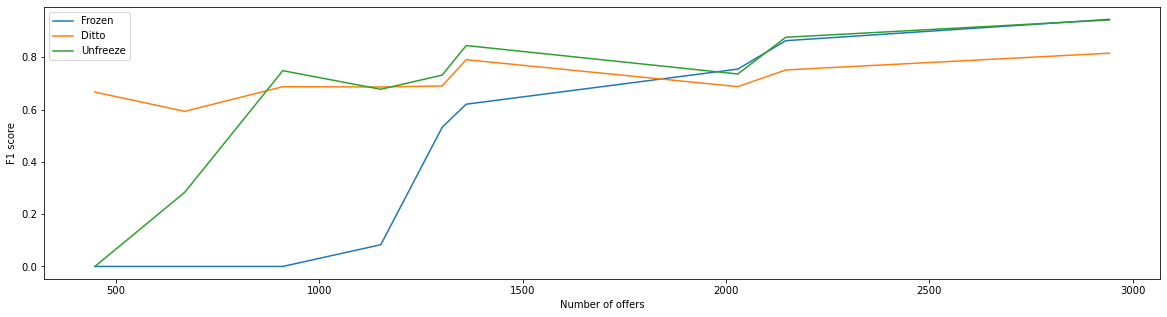

[0 3 6 1 4 7 2 8 5]


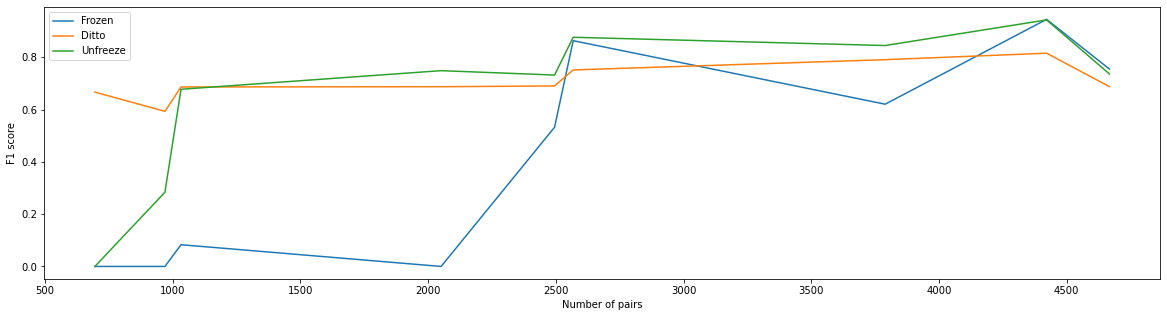

[0 3 6 1 7 8 2 4 5]


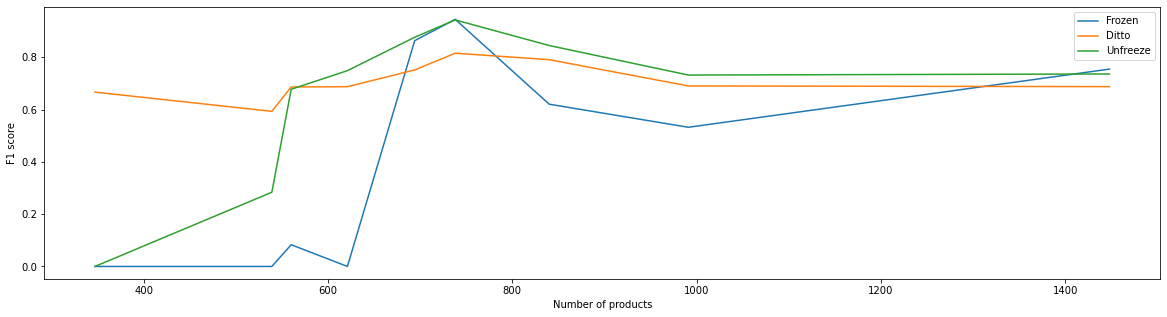

[0 3 6 1 4 2 5 7 8]


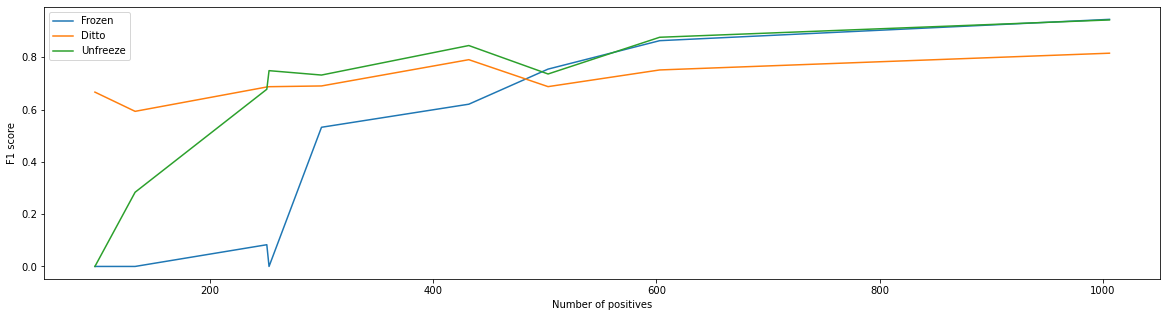

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"]=20,5

for x_axis in ['offers', 'pairs', 'products', 'positives']:
    x = [d[x_axis] for d in data_for_samples.values()]
    sorted_indices = np.argsort(x)
    print(sorted_indices)
    x = np.array(x)[sorted_indices]

    y_frozen = np.array([d['frozen'] for d in data_for_samples.values()])[sorted_indices]
    y_ditto = np.array([d['ditto'] for d in data_for_samples.values()])[sorted_indices]
    y_unfreeze = np.array([d['unfreeze'] for d in data_for_samples.values()])[sorted_indices]

    plt.plot(x, y_frozen, label='Frozen')
    plt.plot(x, y_ditto, label='Ditto')
    plt.plot(x, y_unfreeze, label='Unfreeze')

    plt.xlabel(f'Number of {x_axis}')
    plt.ylabel('F1 score')
    plt.legend()
    plt.show()

# Interpretability

In [11]:
import pandas as pd
import numpy as np
np.random.seed(42)
import random
random.seed(42)

import time
from pathlib import Path
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
from transformers import AutoTokenizer
import string